In [111]:
%matplotlib inline

In [115]:
import numpy as np
from scipy.stats import vonmises
from scipy.ndimage import convolve
from thllib import flylib
from matplotlib import pyplot as plt
import sys
from scipy import stats

flynum = 1331#int(sys.argv[1])

fly = flylib.NetFly(flynum)

fly.open_signals('hdf5')

angles = np.linspace(0,360,360*2)[:-1]

In [116]:
def fly_pdf(x,mu,k1,k2):
    return (stats.vonmises.pdf(x,k1,loc = mu) + stats.vonmises.pdf(x,k2,loc = mu+np.pi))/2.0

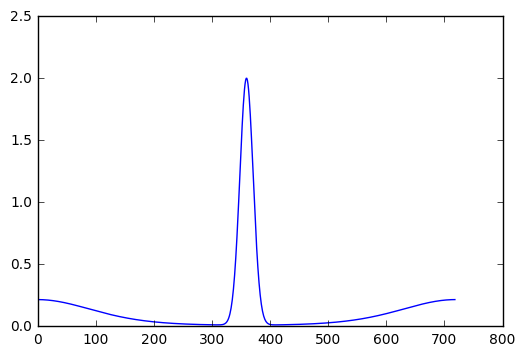

In [161]:
angles = np.linspace(0,360,360*2)[:-1]

state_kernel = fly_pdf(np.deg2rad(angles),np.pi,100,1.5)
vel_kernel = fly_pdf(np.deg2rad(angles),np.pi,100.0,0.01)

plt.plot(state_kernel)

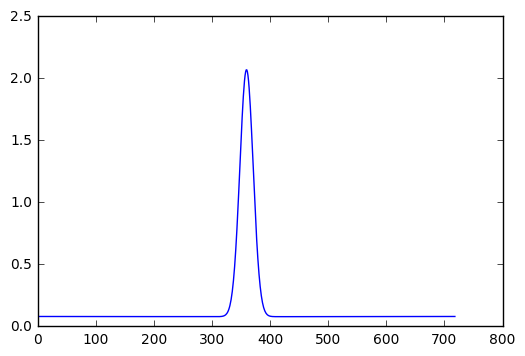

In [181]:
plt.plot(vel_kernel)

In [163]:
imkernel = np.vstack([state_kernel])

In [164]:
observed_values = convolve(fly.correlations,imkernel,mode = 'wrap')

In [167]:
import numpy as np
from scipy.stats import vonmises
from scipy.ndimage import convolve
from thllib import flylib
from matplotlib import pyplot as plt
import sys

#flynum = 1328#int(sys.argv[1])

#fly = flylib.NetFly(flynum)

#fly.open_signals('hdf5')

state_kernel = None

def predict(state_pdf,velocity,kernel):
    p = convolve(np.roll(state_pdf, velocity), kernel, mode='wrap')
    return p/np.sum(p)

def estimate_state(prediction,observation,kernel = None):
    """estimate the state given a observation likelyhood and prediction likelyhood
    and a kernel describing the state confidence"""
    if kernel is None:
        return observation*prediction
    else:
        return convolve(observation,kernel,mode = 'wrap')*prediction

def wraped_descrete_vel(like_1,like_2):
    """estimate the descrete velocity of a transition from
    likelyhood1 like_1 to likelyhood2 like2"""
    from scipy.signal import correlate
    return np.argmax(correlate(like_1,like_2))-len(angles)


state_estimates = list()
velocities = list()
predictions = list()

idx_0 = 0
l0 = observed_values[idx_0]
l1 = observed_values[idx_0+1]
v = wraped_descrete_vel(l0,l1)
predictions.append(predict(l1/np.sum(l1),
                           v,vel_kernel))

state_estimates.append(estimate_state(predictions[-1],
                                      observed_values[idx_0+2],state_kernel))

velocities.append(wraped_descrete_vel(l1/np.sum(l1),
                                      state_estimates[-1]))

for i in range(len(fly.correlations)-2):
    predictions.append(predict(state_estimates[-1],
                               velocities[-1],
                               vel_kernel))
    state_estimates.append(estimate_state(predictions[-1],
                                          observed_values[idx_0+2+i],state_kernel))
    velocities.append(wraped_descrete_vel(state_estimates[-2],
                                          state_estimates[-1]))
    if not((i%200)>0):
        print i

0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
5400
5600
5800
6000
6200
6400
6600
6800
7000
7200
7400
7600
7800
8000
8200
8400
8600
8800
9000
9200
9400
9600
9800
10000
10200
10400
10600
10800
11000
11200
11400
11600
11800
12000
12200
12400
12600
12800
13000
13200
13400
13600
13800
14000
14200
14400
14600
14800
15000
15200
15400
15600
15800
16000
16200
16400
16600
16800
17000
17200
17400
17600
17800
18000
18200
18400
18600
18800
19000
19200
19400
19600
19800
20000
20200
20400
20600
20800
21000
21200
21400
21600
21800
22000
22200
22400
22600
22800
23000
23200
23400
23600
23800
24000
24200
24400
24600
24800
25000
25200
25400
25600
25800
26000
26200
26400
26600
26800
27000
27200
27400
27600
27800
28000
28200
28400
28600
28800
29000
29200
29400
29600
29800
30000
30200
30400
30600
30800
31000
31200
31400


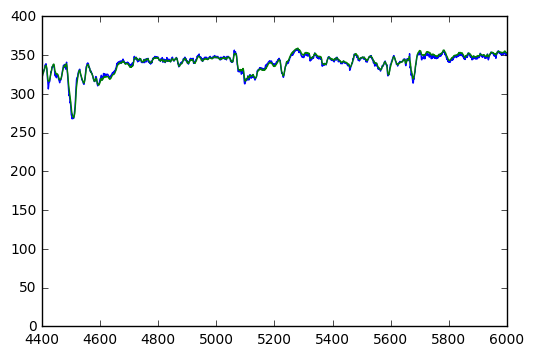

In [123]:
plt.plot(fly.orientations)
plt.plot(angles[np.argmax(state_estimates,axis =1)])
plt.gca().set_xbound(4400,6000)
#plt.twinx()
#plt.plot(velocities,color = 'r')
#plt.gca().set_xbound(0,200)
#plt.gca().set_xbound(1650,1700)
#plt.gca().set_xbound(10000,12000)

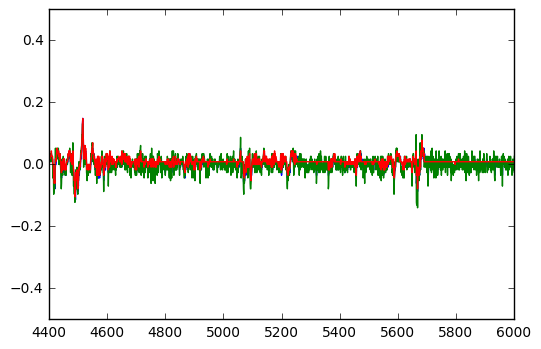

In [168]:
plt.plot(np.diff(np.deg2rad(angles[np.argmax(state_estimates,axis =1)])))
plt.plot(fly.velocity)
plt.plot(np.array(velocities[1:])*2*np.pi/720.*-1)
plt.gca().set_ybound(-0.5,0.5)
plt.gca().set_xbound(4400,6000)
#plt.plot(np.diff(fly.orientations)*-1)
#plt.gca().set_xbound(1650,1700)
#plt.gca().set_ybound(-20,20)

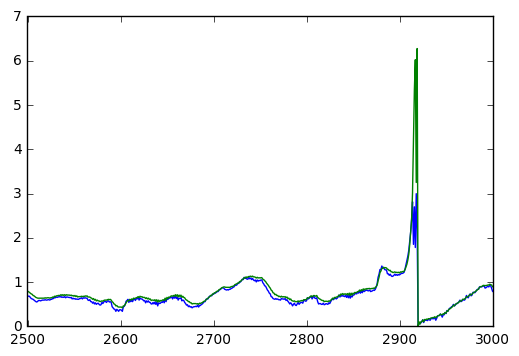

In [180]:
#plt.plot(fly.velocity)
def rewrap(trace,offset = np.pi/2.):
    unwrapped = np.unwrap(trace,1.8*np.pi)
    vel = np.diff(unwrapped)
    return np.mod(unwrapped+np.deg2rad(offset),2*np.pi),vel

x,v = rewrap(np.deg2rad(angles[np.argmax(state_estimates,axis =1)]),offset = -25)
#plt.plot(v)

plt.plot(fly.position)
plt.plot(x)
plt.gca().set_xbound(2500,3000)

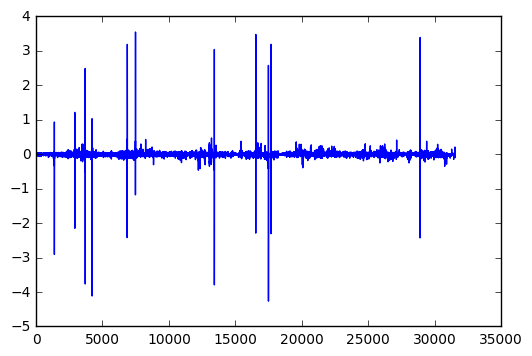

In [173]:
plt.plot(fly.velocity)

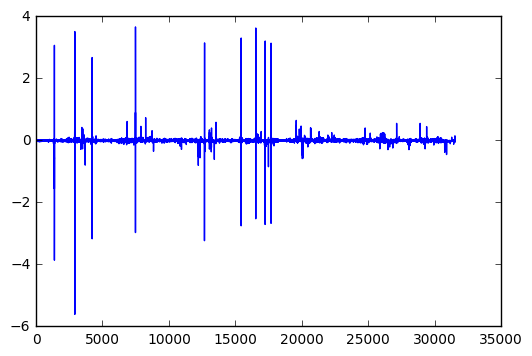

In [174]:
plt.plot(v)

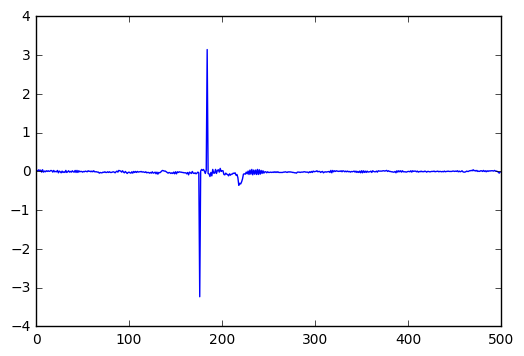

In [175]:
plt.plot(v[12500:13000])

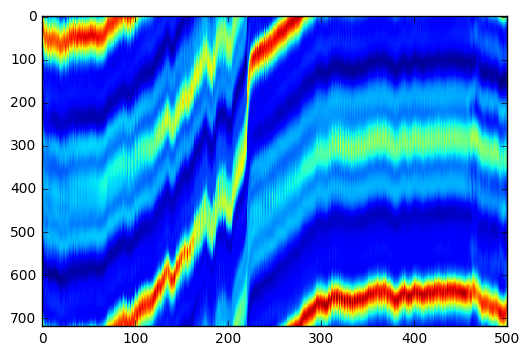

In [176]:
plt.imshow(np.array(fly.correlations[12500:13000]).T,aspect = 'auto',interpolation = 'None')
#plt.imshow(np.array(observed_values[12500:13000]).T,aspect = 'auto',interpolation = 'None')
#plt.imshow(np.array(state_estimates[12500:13000]).T,aspect = 'auto',interpolation = 'None')
#plt.plot(np.rad2deg(x[1300:1500])*2,color = 'k',lw = 5)

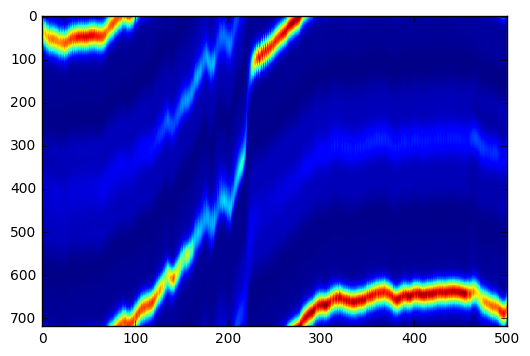

In [177]:
plt.imshow(np.array(state_estimates[12500:13000]).T,aspect = 'auto',interpolation = 'None')

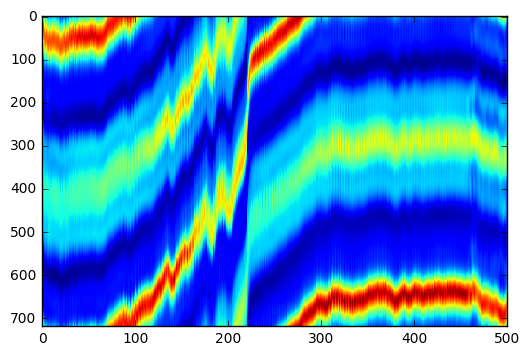

In [179]:
plt.imshow(observed_values[12500:13000].T,aspect = 'auto',interpolation = 'None')